In [ ]:
from pathlib import Path
import os
import sys

dirname = Path(os.path.abspath(''))
root = dirname.parent

sys.path.insert(0, str(root))

In [ ]:
# Constants

WINDOW_SIZE = 32
PREDICTION_SIZE = 4

STYLE_BULLISH = [1, 0, 0]
STYLE_UNKNOWN = [0, 1, 0]
STYLE_BEARISH = [0, 0, 1]

Y_DIM = len(STYLE_BULLISH)

VALIDATION_RATIO = 0.2

BATCH_SIZE = 64

EPOCHS = 100

In [ ]:
import pandas as pd

stock = pd.read_csv(root / 'data' / '15m.csv', index_col=0).drop(columns=['open_time', 'close_time'])

print('length:', len(stock))

print('columns:', stock.columns)

# Remove zero volumn records
stock = stock[
    (stock != 0).all(axis=1)
].dropna()

print('length after cleaned:', len(stock))

stock = stock.iloc[:10000]

stock

length: 39348
columns: Index(['open', 'high', 'low', 'close', 'volume', 'quote_volume',
       'total_trades', 'taker_volume', 'taker_quote_volume'],
      dtype='object')
length after cleaned: 39345


,open,high,low,close,volume,quote_volume,total_trades,taker_volume,taker_quote_volume
0,7145.99,7161.38,7117.12,7137.44,552.274946,3.943150e+06,4627,299.994641,2.142624e+06
1,7137.46,7173.47,7137.45,7151.58,472.460817,3.381481e+06,4308,292.893319,2.096191e+06
2,7151.58,7167.00,7138.39,7156.53,302.007414,2.159535e+06,3728,183.059632,1.308919e+06
3,7156.04,7157.07,7133.52,7136.57,320.142548,2.286677e+06,3319,148.957600,1.063991e+06
4,7136.76,7141.99,7114.33,7120.10,378.542200,2.696923e+06,3524,171.678416,1.223234e+06
...,...,...,...,...,...,...,...,...,...
9995,6590.50,6599.79,6581.19,6598.46,410.816584,2.707478e+06,3801,187.754867,1.237408e+06
9996,6598.49,6609.49,6586.51,6606.05,408.520462,2.695473e+06,3864,237.400316,1.566351e+06
9997,6606.05,6638.00,6606.04,6622.23,997.422802,6.607192e+06,8590,576.481696,3.818843e+06
9998,6622.82,6627.66,6600.24,6609.36,492.504520,3.257754e+06,5285,240.048582,1.588112e+06


In [ ]:
ranges = []

for column_name in stock.columns:
    column = stock[column_name]
    
    ranges.append((
        column_name,
        column.min(),
        column.max()
    ))
    
ranges

[('open', 3888.65, 10488.69),
 ('high', 4240.75, 10500.0),
 ('low', 3782.13, 10436.18),
 ('close', 3882.22, 10488.78),
 ('volume', 35.066062, 14596.107643),
 ('quote_volume', 308773.05142744, 90312985.11437915),
 ('total_trades', 462, 86789),
 ('taker_volume', 14.853535, 7962.468589),
 ('taker_quote_volume', 130811.55505231, 41910148.36916428)]

In [ ]:
from stock_pandas import StockDataFrame


def is_hhv(array) -> bool:
    return array[0] == array.max()


def is_llv(array) -> bool:
    return array[0] == array.min()


stock = StockDataFrame(stock)
        
original_n = len(stock.columns)

stock['is_hhv'] = stock.rolling_calc(
    PREDICTION_SIZE + 1,
    'high',
    is_hhv,
    True
)

stock['is_llv'] = stock.rolling_calc(
    PREDICTION_SIZE + 1,
    'low',
    is_llv,
    True
)

stock

,open,high,low,close,volume,quote_volume,total_trades,taker_volume,taker_quote_volume,is_hhv,is_llv
0,7145.99,7161.38,7117.12,7137.44,552.274946,3.943150e+06,4627,299.994641,2.142624e+06,0.0,0.0
1,7137.46,7173.47,7137.45,7151.58,472.460817,3.381481e+06,4308,292.893319,2.096191e+06,1.0,0.0
2,7151.58,7167.00,7138.39,7156.53,302.007414,2.159535e+06,3728,183.059632,1.308919e+06,1.0,0.0
3,7156.04,7157.07,7133.52,7136.57,320.142548,2.286677e+06,3319,148.957600,1.063991e+06,0.0,0.0
4,7136.76,7141.99,7114.33,7120.10,378.542200,2.696923e+06,3524,171.678416,1.223234e+06,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9995,6590.50,6599.79,6581.19,6598.46,410.816584,2.707478e+06,3801,187.754867,1.237408e+06,0.0,1.0
9996,6598.49,6609.49,6586.51,6606.05,408.520462,2.695473e+06,3864,237.400316,1.566351e+06,NaN,NaN
9997,6606.05,6638.00,6606.04,6622.23,997.422802,6.607192e+06,8590,576.481696,3.818843e+06,NaN,NaN
9998,6622.82,6627.66,6600.24,6609.36,492.504520,3.257754e+06,5285,240.048582,1.588112e+06,NaN,NaN


In [ ]:
import numpy as np


features = stock.to_numpy()[:-PREDICTION_SIZE]

original_n = len(ranges)




def normalize(value, index):
    _, min_value, max_value = ranges[index]
    
    return (value - min_value) / (max_value - min_value) 


def apply_normalizer(array: np.ndarray) -> np.ndarray:
    return [
        normalize(value, i)
        for i, value in enumerate(array)
    ]


def apply_softmax(array: np.ndarray) -> np.ndarray:
    origin = array[:original_n]
    is_hhv, is_llv = array[original_n:]
    
    row = np.append(
        apply_normalizer(origin),
        STYLE_BULLISH if is_llv == 1 else (
            STYLE_BEARISH if is_hhv == 1 else STYLE_UNKNOWN
        )
    )
    
    return row


features = np.array([
    apply_softmax(row)
    for row in features
])

print('inputs length', len(features))

features

inputs length 9996


array([[0.49353337, 0.46661022, 0.50119702, ..., 0.        , 1.        ,
        0.        ],
       [0.49224096, 0.46854176, 0.5042523 , ..., 0.        , 0.        ,
        1.        ],
       [0.49438034, 0.46750809, 0.50439356, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.41155357, 0.37951991, 0.42089404, ..., 0.        , 1.        ,
        0.        ],
       [0.40893995, 0.37653393, 0.41931906, ..., 1.        , 0.        ,
        0.        ],
       [0.40936873, 0.3768886 , 0.42065509, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
def get_labels_from_features(features):
    return features[WINDOW_SIZE - 1:, -Y_DIM:]


def split_by_ratio(features):
    length = len(features)
    validation_length = int(VALIDATION_RATIO * length)
    
    return features[:validation_length], features[-validation_length:]


training_features, validation_features = split_by_ratio(features)

print('training length', len(training_features))
print('validation length', len(validation_features))

training length 1999
validation length 1999


In [ ]:
import tensorflow as tf
from get_rolling_window import rolling_window

train_ds = tf.data.Dataset.from_tensor_slices((
    rolling_window(training_features, WINDOW_SIZE, 1), 
    get_labels_from_features(training_features)
)).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((
    rolling_window(validation_features, WINDOW_SIZE, 1), 
    get_labels_from_features(validation_features)
)).batch(BATCH_SIZE)

train_ds

<BatchDataset shapes: ((None, 32, 12), (None, 3)), types: (tf.float64, tf.float64)>

In [ ]:
from da_rnn import DARNN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Reshape

darnn = DARNN(
    WINDOW_SIZE,
    64,
    64,
    Y_DIM
)

model = Sequential([
    darnn,
    Reshape((-1,), name='reshape')
])


# model.summary()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', 'mae', 'mape']
)

In [ ]:
feature_batch, label_batch = next(iter(train_ds))

print('feature, label shape', feature_batch.shape, label_batch.shape)

print('prediction shape', model(feature_batch).shape)

feature, label shape (64, 32, 12) (64, 3)
prediction shape (64, 3)


In [11]:
save_to = dirname / 'checkpoint.hdf5'

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[
        # Save checkpoints on best validation loss
        tf.keras.callbacks.ModelCheckpoint(
            save_to,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        # Stop early if the model overfits
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    ],
    epochs=EPOCHS,
    verbose=1
)

history

Epoch 1/100
31/31 [==============================] - 103s 704ms/step - loss: 1.0913 - accuracy: 0.3866 - mae: 0.3952 - mape: 59046539.5469 - val_loss: 1.0860 - val_accuracy: 0.4121 - val_mae: 0.3976 - val_mape: 62701404.0000

Epoch 00001: val_loss improved from inf to 1.08601, saving model to /Users/kael/Codes/ml/tensorflow-2-DA-RNN/notebook/checkpoint.hdf5
Epoch 2/100
31/31 [==============================] - 3s 99ms/step - loss: 1.0796 - accuracy: 0.4551 - mae: 0.3996 - mape: 67590376.2500 - val_loss: 1.0659 - val_accuracy: 0.4690 - val_mae: 0.4186 - val_mape: 91766392.0000

Epoch 00002: val_loss improved from 1.08601 to 1.06587, saving model to /Users/kael/Codes/ml/tensorflow-2-DA-RNN/notebook/checkpoint.hdf5
Epoch 3/100
31/31 [==============================] - 3s 100ms/step - loss: 1.0611 - accuracy: 0.4617 - mae: 0.4281 - mape: 104591750.0000 - val_loss: 1.0332 - val_accuracy: 0.4690 - val_mae: 0.4575 - val_mape: 150090992.0000

Epoch 00003: val_loss improved from 1.06587 to 1.0332

In [12]:
history.history

{'loss': [1.090226650238037,
  1.079345464706421,
  1.0580565929412842,
  1.0396584272384644,
  1.0277177095413208,
  1.019587516784668,
  1.0154000520706177,
  1.0136525630950928,
  1.012962818145752,
  1.0126546621322632,
  1.012489914894104,
  1.0123668909072876,
  1.0122640132904053,
  1.0121805667877197,
  1.0121116638183594,
  1.0120469331741333,
  1.0119869709014893,
  1.0119311809539795,
  1.011879324913025,
  1.01183021068573,
  1.0117822885513306,
  1.0117323398590088,
  1.0116780996322632,
  1.01161527633667,
  1.011538028717041,
  1.0114346742630005,
  1.0112740993499756,
  1.0115877389907837,
  1.011108160018921,
  1.0107630491256714,
  1.0135704278945923,
  1.0136173963546753,
  1.0127896070480347,
  1.0126327276229858,
  1.012535810470581],
 'accuracy': [0.3846544623374939,
  0.4390243887901306,
  0.45223575830459595,
  0.45223575830459595,
  0.45223575830459595,
  0.5035569071769714,
  0.5045731663703918,
  0.5045731663703918,
  0.5045731663703918,
  0.5045731663703918,

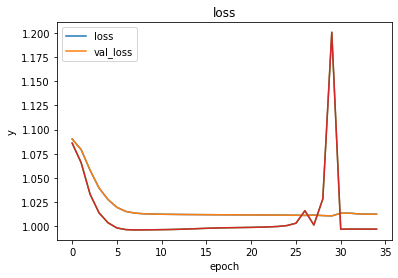

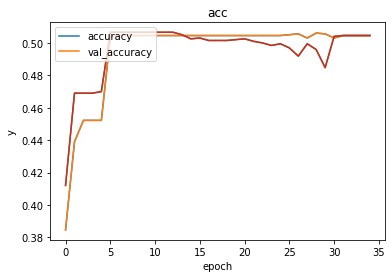

In [16]:
import matplotlib.pyplot as plt


def plot(keys, title='title', ylabel='y'):
    for key in keys:
        plt.plot(history.history[key])
        plt.plot(history.history[key])
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    
    plt.legend(keys, loc='upper left')
    
    plt.show()
    
plot(['loss', 'val_loss'], 'loss')
plot(['accuracy', 'val_accuracy'], 'acc')
